In [1]:
working_dimers = ['CSD20', 'CSD23', 'CSD25', 'CSD26']

with open('../af2/good_models.list', 'r') as f:
    good_models = f.read().splitlines()

# working_models = [x for x in good_models if x.split('/')[-1][:5] in working_dimers]

working_models = []

for working_dimer in working_dimers:
    models_all = [x for x in good_models if x.split('/')[-1][:5] == working_dimer]
    models_A = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'A_')]
    models_B = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'B_')]
    models_AB = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'AB_')]

    working_models.append([models_A, models_B, models_AB, models_AB])

In [2]:
import pyrosetta
pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
}})

In [4]:
# make all combinations of backbones from different AF2 models for each SEC-validated heterodimer
# this will provide MPNN with a good set of backbone diversity for MSD

from itertools import product
from copy import deepcopy

import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.protocols.states import yeet_pose_xyz

sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
sw.chain_order('123456')

for models_A_B_AB, working_dimer in zip(working_models, working_dimers):

    poses_A_B_AB = []
    for model_group, yeet_coords, split in zip(models_A_B_AB, [(1,0,0), (0,1,0), (-1,0,0), (0,-1,0)], [False,False,True,True]):
        pose_group = []
        for pdb_fname in model_group:
            pose = pyrosetta.pose_from_pdb(pdb_fname)
            model_num = pdb_fname.split('/')[-1].split('_')[2]

            if yeet_coords:
                pose = yeet_pose_xyz(pose, yeet_coords)

            if split:
                pose = pose.split_by_chain()

            pose_group.append((pose, model_num))
        poses_A_B_AB.append(pose_group)

    for (pose_A, model_A), (pose_B, model_B), (poses_AB_1, model_AB_1), (poses_AB_2, model_AB_2) in product(*poses_A_B_AB):
        combined_pose = deepcopy(pose_A)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(pose_B), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[2]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[2]), True)
        sw.apply(combined_pose)
        combined_pose.dump_pdb('backbone_combos/' + working_dimer + '_' + model_A + model_B + model_AB_1 + model_AB_2 + '.pdb')

In [3]:
import pyrosetta.distributed.io as io

import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.protocols.mpnn import mpnn_dimers, MPNNDesign

ppose_in = io.pose_from_file('backbone_combos/CSD20_1111.pdb')

pposes = mpnn_dimers(
    packed_pose_in = ppose_in,
    num_sequences = 10,
    batch_size = 10,
    **{
        "mpnn_design_area": 'scan'
    }
)

# iterate first since mpnn_hinge_dimers returns a generator
poses = []
for ppose in pposes:
    poses.append(io.to_pose(ppose))

# then once all sequences are generated, build the structures
mpnn_design = MPNNDesign()
for design_area, pose in zip(['full', 'interface', 'neighborhood'], poses):
    # print(pose)
    for j, mpnn_pose in enumerate(mpnn_design.generate_all_poses(pose)):
        mpnn_pose.dump_pdb(f'test4/CSD20_1111_mpnn_{design_area}_{j}.pdb')

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


0.00 min: Setting up design selectors
0.00 min: Beginning 3 MPNNDesign runs
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,

In [ ]:
# mpnn msd uses lots of RAM sometimes (up to 7.5g for two dimer copies, up to 8.9g for three dimer copies)
# it's also multithreaded which is pretty cool

In [4]:
# extract Y states from all the unique sequences

sbatch_fname = 'mpnn_design_backbones'

from glob import glob

task_lines = []

for bb_fname in sorted(glob('/home/broerman/projects/CSD/round_2/mpnn_upweight_int/backbone_combos/*.pdb')):
    task_lines.append(f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{sbatch_fname}.py {bb_fname}\n")

with open(f'{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /mnt/home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /mnt/home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p short
#SBATCH -c 1
#SBATCH --mem=12G

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/projects/CSD/round_2/mpnn_upweight_int/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat mpnn_design_backbones.tasks | wc -l) mpnn_design_backbones.sh


In [1]:
# alphafold all the unique sequences

from Bio import SeqIO
from collections import defaultdict
from glob import glob
from IPython.utils.io import capture_output
from tqdm.auto import tqdm

len_seq_path = defaultdict(dict)

for file_path in tqdm(sorted(glob(f'/home/broerman/projects/CSD/round_2/mpnn_upweight_int/mpnn_designs/*.pdb'))):
    sequence = ''
    with capture_output() as captured: # otherwise memory overloads lol
        for i, record in enumerate(SeqIO.parse(file_path, 'pdb-atom')):
            sequence += str(record.seq)

    if sequence not in len_seq_path[len(sequence)]:
        len_seq_path[len(sequence)][sequence] = file_path

100%|██████████| 8610/8610 [39:17<00:00,  3.65it/s]


In [2]:
import json
json.dump(len_seq_path, open('mpnn_designs_unique_seqs.json', 'w'))

In [1]:
import json
len_seq_path = json.load(open('mpnn_designs_unique_seqs.json', 'r'))

In [2]:
num_seqs = 0
for length, seq_path in len_seq_path.items():
    num_seqs += len(seq_path)
print(num_seqs)

8562


In [3]:
# look at distribution of percent sequence identity of each design to the original, as well as the sequence diversity of all designs
from collections import defaultdict

# bin seqs by parent backbone and extent of redesign

all_seqs_designs = {}
binned_sequences = defaultdict(list)

for length, seqs_designs in len_seq_path.items():
    all_seqs_designs.update(seqs_designs)

for seq, path in all_seqs_designs.items():
    path_split = path.split('/')[-1].split('_')
    design_id = path_split[0] + '_' + path_split[2]
    binned_sequences[design_id].append(seq)

In [4]:
from Bio import SeqIO
from glob import glob
from IPython.utils.io import capture_output

len_seq_path = defaultdict(dict)

orig_seqs = {}

for design_id in binned_sequences.keys():
    file_path = glob('/home/broerman/projects/CSD/round_2/mpnn_upweight_int/backbone_combos/' + design_id.split('_')[0] + '*.pdb')[0]
    sequence = ''
    with capture_output() as captured: # otherwise memory overloads lol
        for i, record in enumerate(SeqIO.parse(file_path, 'pdb-atom')):
            sequence += str(record.seq)
    orig_seqs[design_id] = sequence

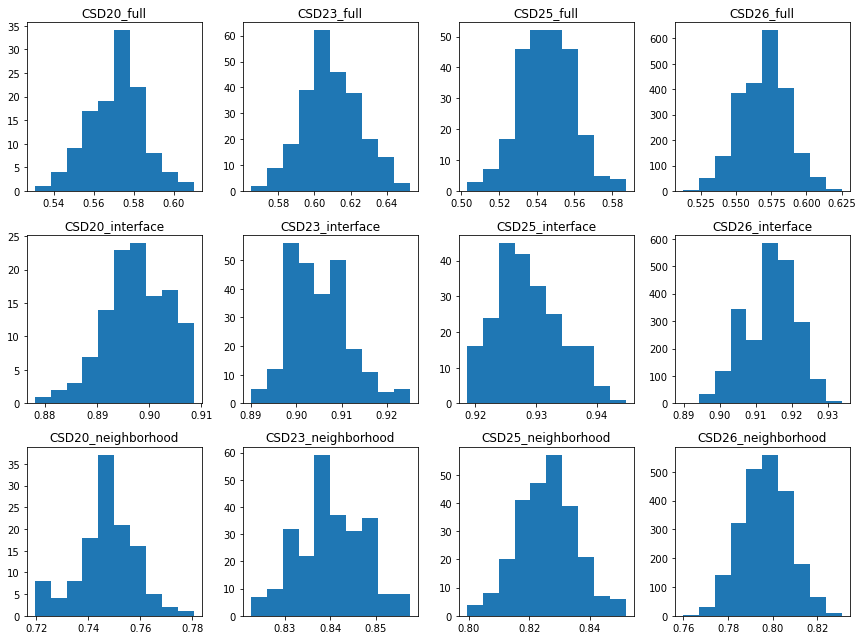

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for (design_id, seqs), ax in zip(binned_sequences.items(), axs.T.flatten()):
    orig_seq = orig_seqs[design_id]
    seq_len = len(orig_seq)
    similarities = []
    for seq in seqs:
        similarities.append(sum([seq[i] == orig_seq[i] for i in range(seq_len)]) / seq_len)

    ax.hist(similarities)
    ax.set_title(design_id)
    
fig.tight_layout()
fig.savefig('similarities_to_input.png')

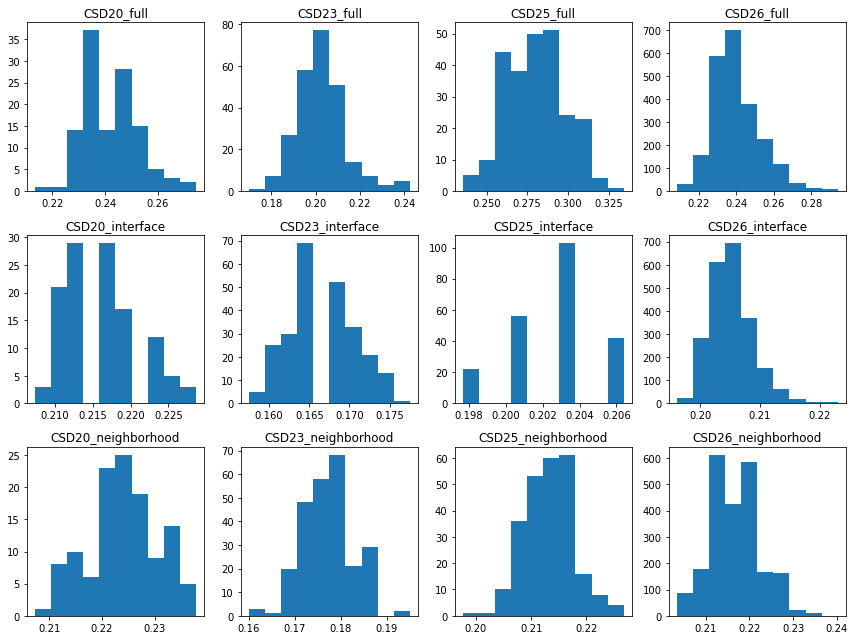

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for (design_id, seqs), ax in zip(binned_sequences.items(), axs.T.flatten()):
    ala_frac = []
    for seq in seqs:
        seq_len = len(seq)
        ala_frac.append(seq.count('A') / seq_len)

    ax.hist(ala_frac)
    ax.set_title(design_id)
    
fig.tight_layout()
fig.savefig('fraction_alanine.png')

CSD20_full 0.7854420731707317
CSD20_interface 0.9447163370369668
CSD20_neighborhood 0.8788274898373984
CSD23_full 0.73900064
CSD23_interface 0.9425128626957631
CSD23_neighborhood 0.9070152
CSD25_full 0.7810846511627906
CSD25_interface 0.9651797626858503
CSD25_neighborhood 0.9177373953488372
CSD26_full 0.7321411861534737
CSD26_interface 0.939747966332155
CSD26_neighborhood 0.8684896451222465


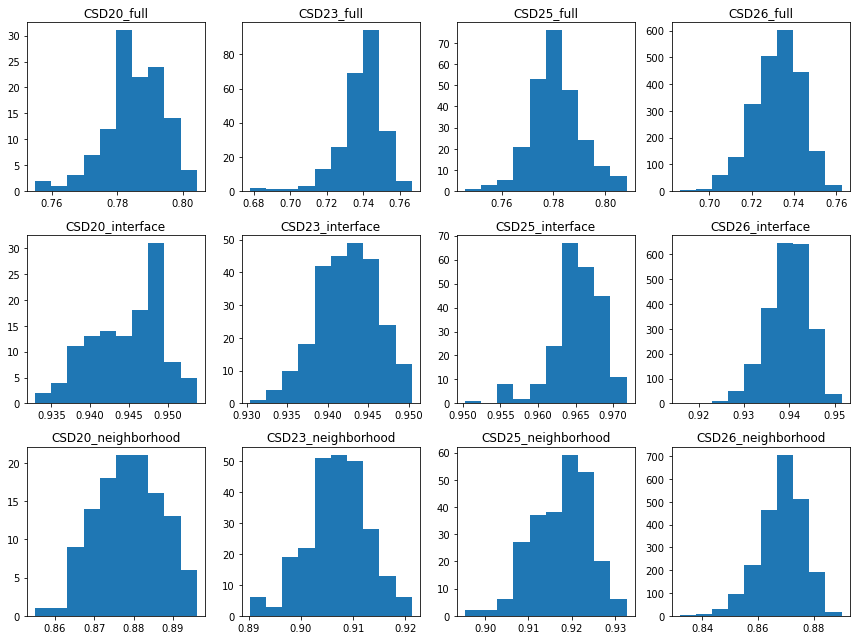

In [7]:
# how do you come up with a number for the sequence diversity of all designs against each other?
# for each design, compute its sequence diversity against all other designs, average them, then average all these averages

# could find a smarter way to do this with matrix multiplication, but ehh

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for (design_id, seqs), ax in zip(binned_sequences.items(), axs.T.flatten()):
    mean_similarities = []
    for base_seq in seqs:
        seq_len = len(base_seq)
        mean_similarity = np.mean([np.sum([seq[i] == base_seq[i] for i in range(seq_len)]) / seq_len for seq in seqs])
        mean_similarities.append(mean_similarity)
    ax.hist(mean_similarities)
    ax.set_title(design_id)
    print(design_id, np.mean(mean_similarities))

fig.tight_layout()
fig.savefig('similarities_among_designs.png')

Very interesting, so compared to the design model, the MPNN designs have lower similarity than among themselves!
Makes sense- likely there are some positions in the structure which MPNN usually mutates to the same different residue ID. In other words, there are some specific mutations from the original design which MPNN favors.

In [4]:
# extract Y states from all the unique sequences

sbatch_fname = 'split_Y_designs'

from more_itertools import chunked

unique_paths = []
for length, seq_path in len_seq_path.items():
    unique_paths += list(seq_path.values())

task_lines = []
for path_chunk in chunked(unique_paths, 100):
    task_lines.append(f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{sbatch_fname}.py {' '.join(path_chunk)}\n")

with open(f'{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /mnt/home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /mnt/home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p short
#SBATCH -c 1
#SBATCH --mem=1536M

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/projects/CSD/round_2/mpnn_upweight_int/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat split_Y_designs.tasks | wc -l) split_Y_designs.sh


In [5]:
# alphafold
# bins proteins with the same total length in one prediction
# this should prevent the model from needing to be rebuilt for different lengths, while still allowing me to split the jobs across different nodes
# further chunks for more parallelization

from more_itertools import chunked

task_lines = []

for length, seq_path in len_seq_path.items():
    for file_chunk in chunked(seq_path.values(), 230):
        file_str = ' '.join(reversed([x[:-4].replace('mpnn_designs', 'unique_mpnn_Y_designs') + '_AB_Y.pdb' for x in file_chunk]))
        task_lines.append(f"/home/rdkibler/software/superfold/superfold {file_str} --simple_rmsd --initial_guess --models all --max_recycles 4 --out_dir /home/broerman/projects/CSD/round_2/mpnn_upweight_int/unique_mpnn_Y_af2\n")

task_lines.reverse()

sbatch_fname = 'af2_mpnn_Y_designs'

with open(f'{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p gpu
#SBATCH -c 2
#SBATCH --mem=6G
#SBATCH --gres=gpu:rtx2080ti:1

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/projects/CSD/round_2/mpnn_upweight_int/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat af2_mpnn_Y_designs.tasks | wc -l) af2_mpnn_Y_designs.sh


In [7]:
from glob import glob
with open('unique_mpnn_Y_af2_scores.json', 'w') as score_file:
    score_file.write('{')
    for ind_score_path in sorted(glob('unique_mpnn_Y_af2/*.json')):
        ind_score_path_split = ind_score_path.split('/')
        name = ind_score_path_split[-1][:-24]
        with open(ind_score_path, 'r') as ind_score_file:
            contents = ind_score_file.read()
            content_end = contents.find('}')
            contents = '"' + name + '":' + contents[:content_end+1].replace(' ', '').replace('\n', '') + ',\n'
            score_file.write(contents)
    score_file.write('}')

In [8]:
import pandas as pd
scores_df = pd.read_json('unique_mpnn_Y_af2_scores.json', orient='index')

from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(scores_df)

,mean_plddt,recycles,tol,model,type,seed,rmsd_to_input,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_interaction,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_pae_intra_chain,mean_pae,pTMscore,elapsed_time
CSD20_111_full_0_AB_Y_model_1_ptm_seed_0,96.629387,4,3.010552,1,monomer_ptm,0,9.134451,26.012844,25.557861,25.785353,2.664663,2.257559,2.461111,14.128551,0.538078,244.142474
CSD20_111_full_0_AB_Y_model_2_ptm_seed_0,95.309937,4,0.967259,2,monomer_ptm,0,10.777146,28.312353,27.748766,28.030560,2.846421,2.215160,2.530790,15.285163,0.511665,56.841699
CSD20_111_full_0_AB_Y_model_3_ptm_seed_0,96.268456,4,0.964093,3,monomer_ptm,0,8.488046,28.245234,27.663065,27.954149,2.740602,2.197530,2.469066,15.220641,0.518718,57.238011
CSD20_111_full_0_AB_Y_model_4_ptm_seed_0,95.628143,4,0.312819,4,monomer_ptm,0,8.457017,28.174196,27.651560,27.912878,2.726438,2.240301,2.483370,15.205062,0.517583,57.447873
CSD20_111_full_0_AB_Y_model_5_ptm_seed_0,97.187355,4,1.235245,5,monomer_ptm,0,17.227060,27.383789,26.677704,27.030746,2.428382,2.023293,2.225838,14.634046,0.523255,57.217913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CSD26_553_neighborhood_9_AB_Y_model_1_ptm_seed_0,94.885956,4,1.558376,1,monomer_ptm,0,16.369131,27.057514,26.874079,26.965797,3.974677,2.932053,3.453365,15.227156,0.532856,396.609676
CSD26_553_neighborhood_9_AB_Y_model_2_ptm_seed_0,94.256180,4,0.916652,2,monomer_ptm,0,16.830259,28.000776,27.849710,27.925243,4.056689,2.899046,3.477868,15.723059,0.515102,91.727224
CSD26_553_neighborhood_9_AB_Y_model_3_ptm_seed_0,95.137260,4,0.749453,3,monomer_ptm,0,15.664867,28.194609,27.990736,28.092672,3.800986,2.989531,3.395259,15.766117,0.513662,91.581882
CSD26_553_neighborhood_9_AB_Y_model_4_ptm_seed_0,93.683464,4,0.889115,4,monomer_ptm,0,9.428436,28.892342,28.987549,28.939945,4.163044,3.151018,3.657031,16.317663,0.503717,91.800364


6it [00:00,  7.55it/s]


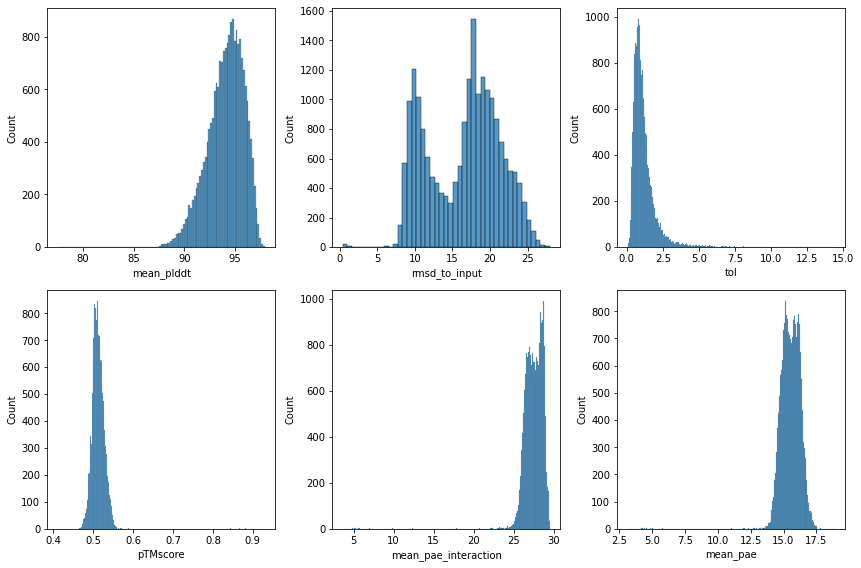

In [10]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.utils.plotting import histplot_df

cols = [
        "mean_plddt",
        "rmsd_to_input",
        "tol",
        "pTMscore",
        "mean_pae_interaction",
        "mean_pae"
    ]

# make sure all the columns to plot are numeric
fig, axs = histplot_df(scores_df, cols=cols)

In [11]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

In [29]:
# Filter designs

cutoffs = [
    # ('mean_plddt', 85, 1),
    ('rmsd_to_input', 3, 0),
    # ('tol', 1, 0)
]

filtered_df = filter_df(scores_df, cutoffs)
filtered_df

31


,mean_plddt,recycles,tol,model,type,seed,rmsd_to_input,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_interaction,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_pae_intra_chain,mean_pae,pTMscore,elapsed_time
CSD20_151_interface_9_AB_Y_model_2_ptm_seed_0,95.798759,4,0.079333,2,monomer_ptm,0,0.414059,3.656541,3.597531,3.627036,2.611556,2.582283,2.596920,3.165269,0.929809,57.152646
CSD20_351_interface_1_AB_Y_model_3_ptm_seed_0,94.397652,4,0.113534,3,monomer_ptm,0,0.735123,4.330067,4.661396,4.495731,2.749171,3.207245,2.978208,3.788677,0.912833,56.779284
CSD20_351_interface_6_AB_Y_model_1_ptm_seed_0,95.070877,4,0.071950,1,monomer_ptm,0,0.672192,4.024634,3.892107,3.958370,2.859179,2.718926,2.789052,3.429926,0.917810,58.216789
CSD25_131_neighborhood_4_AB_Y_model_1_ptm_seed_0,93.257431,4,0.055695,1,monomer_ptm,0,0.896960,4.707980,5.128904,4.918442,3.533282,3.768774,3.651028,4.344973,0.908040,62.911491
CSD25_311_neighborhood_6_AB_Y_model_1_ptm_seed_0,93.230423,4,0.056352,1,monomer_ptm,0,0.718645,5.283978,5.219514,5.251746,4.182727,3.411818,3.797273,4.586757,0.895096,63.228890
CSD25_411_neighborhood_5_AB_Y_model_1_ptm_seed_0,94.291054,4,0.138648,1,monomer_ptm,0,0.880679,4.608759,4.578870,4.593815,3.569273,3.198790,3.384032,4.047790,0.911572,64.065257
CSD25_411_neighborhood_8_AB_Y_model_1_ptm_seed_0,93.392342,4,0.066015,1,monomer_ptm,0,0.859160,5.052388,5.049619,5.051003,3.789704,3.433265,3.611485,4.394326,0.902036,63.898478
CSD26_153_interface_0_AB_Y_model_1_ptm_seed_0,92.414238,4,0.100591,1,monomer_ptm,0,0.595698,6.140304,5.898117,6.019211,4.864158,3.574503,4.219331,5.169480,0.871291,91.034792
CSD26_212_interface_5_AB_Y_model_1_ptm_seed_0,93.720459,4,0.240775,1,monomer_ptm,0,0.555640,7.422854,7.072772,7.247813,6.527853,3.043585,4.785719,6.065533,0.865589,93.136534
CSD26_231_neighborhood_0_AB_Y_model_1_ptm_seed_0,92.413521,4,0.093827,1,monomer_ptm,0,1.151547,6.463163,6.374064,6.418613,5.182376,3.455705,4.319040,5.407731,0.844581,91.651255


6it [00:00, 42.98it/s]


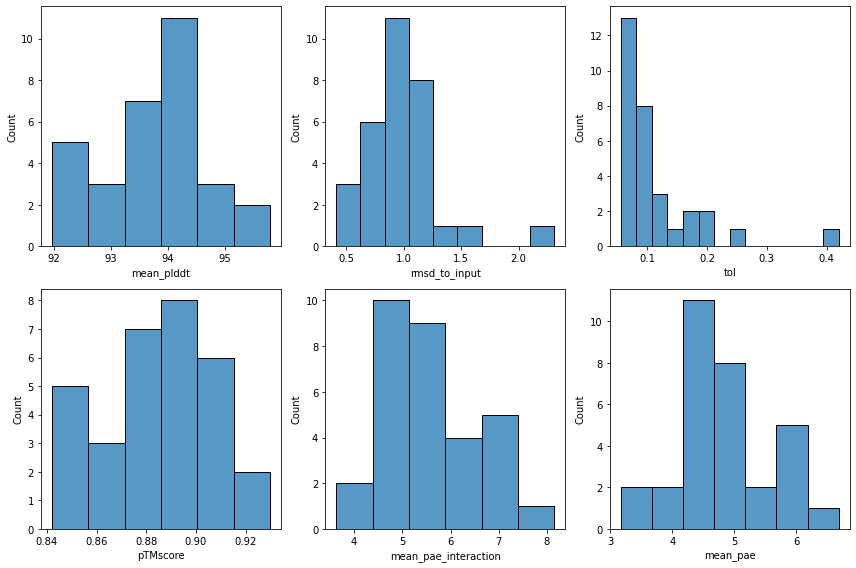

In [30]:
fig, axs = histplot_df(filtered_df, cols=cols)

In [14]:
# copy designs

import shutil

for index in filtered_df.index:
    af2_fname = 'unique_mpnn_Y_af2/' + index + '_unrelaxed.pdb'
    shutil.copy(af2_fname, 'selected_designs/')

In [31]:
# add sequences to df

from Bio import SeqIO
from IPython.utils.io import capture_output

for index in filtered_df.index:
    af2_fname = 'unique_mpnn_Y_af2/' + index + '_unrelaxed.pdb'
    sequence = ''
    with capture_output() as captured: # otherwise memory overloads lol
        for i, record in enumerate(SeqIO.parse(af2_fname, 'pdb-atom')):
            sequence += str(record.seq)
    filtered_df.at[index, 'sequence'] = sequence

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [32]:
# look at distribution of percent sequence identity of each design to the original, as well as the sequence diversity of all designs
from collections import defaultdict

# bin seqs by parent backbone and extent of redesign

all_seqs_designs = {}
binned_sequences = defaultdict(list)

for index, row in filtered_df.iterrows():
    sequence = row['sequence']
    index_split = index.split('_')
    design_id = index_split[0] + '_' + index_split[2]
    binned_sequences[design_id].append(sequence)

In [33]:
from Bio import SeqIO
from glob import glob
from IPython.utils.io import capture_output

len_seq_path = defaultdict(dict)

orig_seqs = {}

for design_id in binned_sequences.keys():
    file_path = glob('/home/broerman/projects/CSD/round_2/mpnn/backbone_combos/' + design_id.split('_')[0] + '*.pdb')[0]
    sequence = ''
    with capture_output() as captured: # otherwise memory overloads lol
        for i, record in enumerate(SeqIO.parse(file_path, 'pdb-atom')):
            if i < 2:
                sequence += str(record.seq)
            else:
                break
    orig_seqs[design_id] = sequence

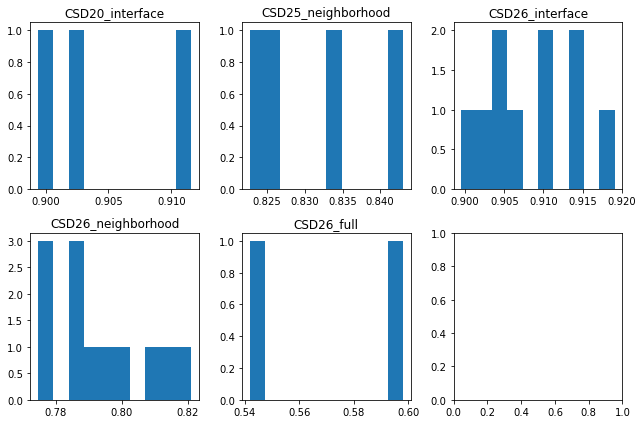

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

for (design_id, seqs), ax in zip(binned_sequences.items(), axs.flatten()):
    orig_seq = orig_seqs[design_id]
    seq_len = len(orig_seq)
    similarities = []
    for seq in seqs:
        similarities.append(sum([seq[i] == orig_seq[i] for i in range(seq_len)]) / seq_len)

    ax.hist(similarities)
    ax.set_title(design_id)
    
fig.tight_layout()

CSD20_interface 0.9613821138211383
CSD25_neighborhood 0.9295058139534884
CSD26_interface 0.9468137254901962
CSD26_neighborhood 0.9071010348583878
CSD26_full 0.8443627450980392


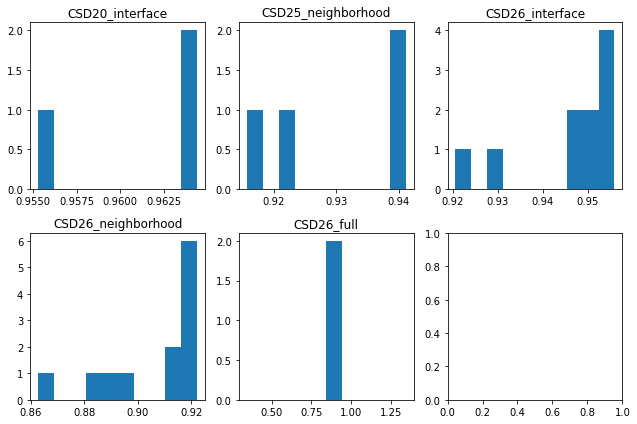

In [35]:
# how do you come up with a number for the sequence diversity of all designs against each other?
# for each design, compute its sequence diversity against all other designs, average them, then average all these averages

# could find a smarter way to do this with matrix multiplication, but ehh

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(9,6))

for (design_id, seqs), ax in zip(binned_sequences.items(), axs.flatten()):
    mean_similarities = []
    for base_seq in seqs:
        seq_len = len(base_seq)
        mean_similarity = np.mean([np.sum([seq[i] == base_seq[i] for i in range(seq_len)]) / seq_len for seq in seqs])
        mean_similarities.append(mean_similarity)
    ax.hist(mean_similarities)
    ax.set_title(design_id)
    print(design_id, np.mean(mean_similarities))

fig.tight_layout()